# 05.12 - Gaussian Mixture Models

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np

### Motivating GMM: Weaknesses of k-Means

As we saw in the previous section, given simple, well-separated data, k-means finds suitable clustering results.

In [2]:
# Generate some data
from sklearn.datasets.samples_generator import make_blobs
X, y_true = make_blobs(n_samples=400, centers=4,
                       cluster_std=0.60, random_state=0)
X = X[:, ::-1] # flip axes for better plotting

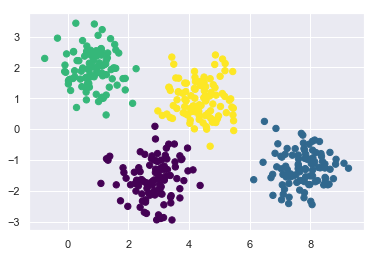

In [3]:
# Plot the data with K Means Labels
from sklearn.cluster import KMeans
kmeans = KMeans(4, random_state=0)
labels = kmeans.fit(X).predict(X)
plt.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis');

Unfortunately, the k-means model has no intrinsic measure of probability or uncertainty of cluster assignments (for example, those at the frontier). For this, we must think about generalizing the model.

One way to think about the k-means model is that it places a circle (or, in higher dimensions, a hyper-sphere) at the **center** of each cluster, with a **radius defined by the most distant point in the cluster**. 

This radius acts as a **hard cutoff** for cluster assignment within the training set: any point outside this circle is not considered a member of the cluster.

In [4]:
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist

def plot_kmeans(kmeans, X, n_clusters=4, rseed=0, ax=None):
    labels = kmeans.fit_predict(X)

    # plot the input data
    ax = ax or plt.gca()
    ax.axis('equal')
    ax.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis', zorder=2)

    # plot the representation of the KMeans model
    centers = kmeans.cluster_centers_
    radii = [cdist(X[labels == i], [center]).max()
             for i, center in enumerate(centers)]
    for c, r in zip(centers, radii):
        ax.add_patch(plt.Circle(c, r, fc='#CCCCCC', lw=3, alpha=0.5, zorder=1))

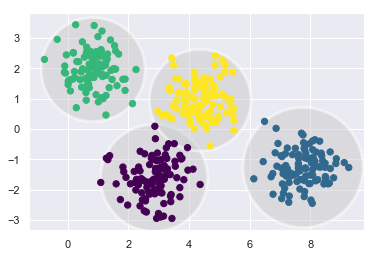

In [5]:
kmeans = KMeans(n_clusters=4, random_state=0)
plot_kmeans(kmeans, X)

Please note that these cluster boundaries can be **only** circular. So, what happens in case of significant overlap?

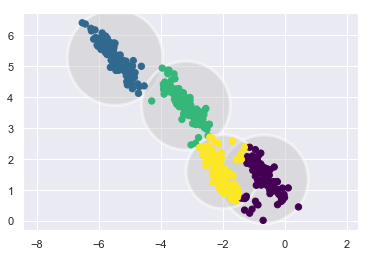

In [6]:
rng = np.random.RandomState(13)
X_stretched = np.dot(X, rng.randn(2, 2))

kmeans = KMeans(n_clusters=4, random_state=0)
plot_kmeans(kmeans, X_stretched)

These are the two main disadvantages of k-means: 

1. **Flexibility in cluster shape**
2. **Probabilistic cluster assignment**

This results in sometimes poor performance in real-world deployment, especially for low-dimensional datasets.  

By generalizing the model to go beyond these limitations we can construct a different class of models known as **Gaussian Mixture Models**. 

### Generalizing E–M: Gaussian Mixture Models

A Gaussian mixture model (GMM) attempts to find a mixture of multi-dimensional Gaussian probability distributions that best model any input dataset.

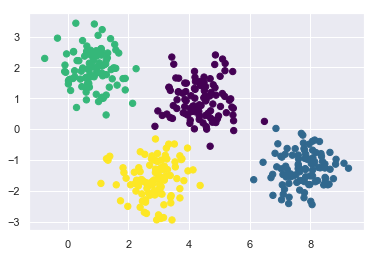

In [10]:
from sklearn.mixture import GaussianMixture as GMM
gmm = GMM(n_components=4).fit(X)
labels = gmm.predict(X)
plt.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis');

GMM contains a probabilistic model under the hood, so it is also possible to find probabilistic cluster assignments.

In [11]:
probs = gmm.predict_proba(X)
print(probs[:5].round(3))

[[0.537 0.463 0.    0.   ]
 [0.    0.    0.    1.   ]
 [0.    0.    0.    1.   ]
 [1.    0.    0.    0.   ]
 [0.    0.    0.    1.   ]]


We can make this clear by making the size of the point proportional to probability:

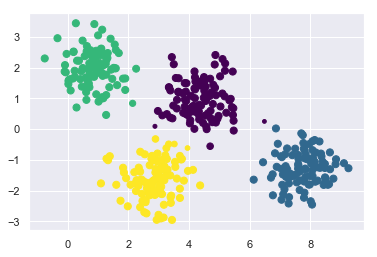

In [12]:
size = 50 * probs.max(1) ** 2  # square emphasizes differences
plt.scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis', s=size);

Under the hood, a Gaussian mixture model is very similar to k-means: it uses an expectation–maximization approach which qualitatively does the following:

1. Choose starting guesses for the location and shape

2. Repeat until converged:
    * E-step: for each point, find weights encoding the probability of membership in each cluster
    * M-step: for each cluster, update its location, normalization, and shape based on all data points, making use of the weights

In [17]:
from matplotlib.patches import Ellipse

def draw_ellipse(position, covariance, ax=None, **kwargs):
    """Draw an ellipse with a given position and covariance"""
    ax = ax or plt.gca()
    
    # Convert covariance to principal axes
    if covariance.shape == (2, 2):
        U, s, Vt = np.linalg.svd(covariance)
        angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
        width, height = 2 * np.sqrt(s)
    else:
        angle = 0
        width, height = 2 * np.sqrt(covariance)
    
    # Draw the Ellipse
    for nsig in range(1, 4):
        ax.add_patch(Ellipse(position, nsig * width, nsig * height,
                             angle, **kwargs))
        
def plot_gmm(gmm, X, label=True, ax=None):
    ax = ax or plt.gca()
    labels = gmm.fit(X).predict(X)
    if label:
        ax.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis', zorder=2)
    else:
        ax.scatter(X[:, 0], X[:, 1], s=40, zorder=2)
    ax.axis('equal')
    
    w_factor = 0.2 / gmm.weights_.max()
    for pos, covar, w in zip(gmm.means_, gmm.covariances_, gmm.weights_):
        draw_ellipse(pos, covar, alpha=w * w_factor)

Graphically, it looks like this:

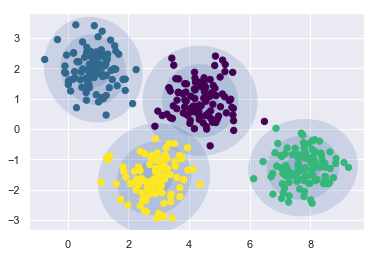

In [18]:
gmm = GMM(n_components=4, random_state=42)
plot_gmm(gmm, X)

### Choosing the covariance type

The <code>covariance</code> hyperparameter controls the degrees of freedom in the shape of each cluster; it is essential to set this carefully for any given problem.

1. [Default] <code>covariance_type="diag"</code> means that the size of the cluster along each dimension can be set independently, with the resulting ellipse constrained to align with the axes;

2. <code>covariance_type="spherical"</code> constrains the shape of the cluster such that all dimensions are equal;

3. <code>covariance_type="full"</code> allows each cluster to be modeled as an ellipse with arbitrary orientation.

### GMM as Density Estimation

The result of a GMM fit to some data is technically not a clustering model, but a _generative probabilistic model describing the distribution of the data_.

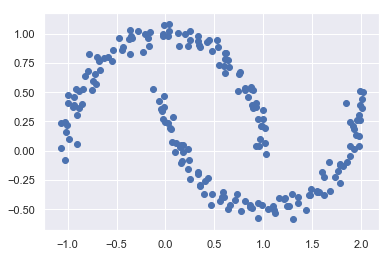

In [19]:
# example
from sklearn.datasets import make_moons
Xmoon, ymoon = make_moons(200, noise=.05, random_state=0)
plt.scatter(Xmoon[:, 0], Xmoon[:, 1]);

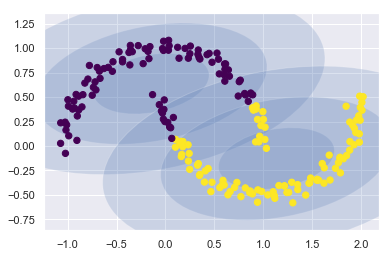

In [21]:
# two-components GMM
gmm2 = GMM(n_components=2, covariance_type='full', random_state=0)
plot_gmm(gmm2, Xmoon)

Not very useful. But increasing the components and ignoring labels can give us an interesting approximation of the input data:

gmm16 = GMM(n_components=16, covariance_type='full', random_state=0)
plot_gmm(gmm16, Xmoon, label=False)

Here the mixture of 16 Gaussians serves _not to find separated clusters of data_, but rather to model the overall **distribution** of the input data. We can then use this to generate more points for the distribution.

### How many components?

A generative model is inherently a probability distribution for the dataset, and so we can simply evaluate the **likelihood** of the data under the model, using cross-validation to avoid over-fitting. 

Other methods commonly employed are the Akaike information criterion (AIC) or the Bayesian information criterion (BIC).

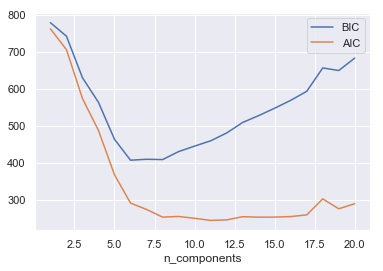

In [24]:
n_components = np.arange(1, 21)
models = [GMM(n, covariance_type='full', random_state=0).fit(Xmoon)
          for n in n_components]

plt.plot(n_components, [m.bic(Xmoon) for m in models], label='BIC')
plt.plot(n_components, [m.aic(Xmoon) for m in models], label='AIC')
plt.legend(loc='best')
plt.xlabel('n_components');

**Note**: this choice of number of components measures how well GMM works as a **density estimator**, not how well it works as a clustering algorithm. 